# Automated Model Discovery for Heart Tissue


Heart Data Reference: http://www.sciencedirect.com/science/article/pii/S1742706115300039

Code by Denisa Martonová & Skyler St. Pierre & Kevin Linka \\
Last edited July 2025


## Problem description

A hyperelastic or Green-elastic materials with can directly be defined by the Piola stress
$$
 {J \, {\mathbf\sigma}
= \frac{\partial \psi}{\partial\mathbf{F}}
  \cdot \mathbf{F}^{\rm{t}}
 }
$$
in dependency of the free energy function $\Psi$ and the deforation gradient $\mathbf{F}$. Now, by contraining the material symmetry to the special case of orthotropy, the free energy function can be given as a function of the strain invariants as $\Psi(I_1, \, I_2,\, I_{4f},...I_{8sn}).$


We can further constrain the choice of the free energy function $\psi$ for the special case of perfect incompressibility for which the Jacobian remains constant and equal to one, $J=I_3 = 1$. So we obtain for the Cauchy stress tensor
$$
  \sigma
= (\frac{\partial \psi}{\partial I_1} \frac{\partial I_1}{\partial \mathbf{F}}
+ \frac{\partial \psi}{\partial I_2} \frac{\partial I_2}{\partial \mathbf{F}}+ ... )  \cdot \mathbf{F}^{\rm{t}}
- p\, \mathbf I .     
$$




### 0. Load python packages

In [ ]:
# matplotlib 3.7 and above removed key plotting features used in this notebook; tensorflow is starting to move some aspects to legacy in 2.13.0 but it will run still
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0

In [1]:
# import necessary python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from colorsys import rgb_to_hls
import seaborn as sns
import matplotlib.colors as mcolors



# Check Versions
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__) # must be 3.2.2
print('Tensorflow: ' + tf.__version__)
#print('Keras: ' + keras.__version__) # comment out if using tf 2.13.0

Numpy: 2.0.2
Matplotlib: 3.10.0
Tensorflow: 2.19.0


In [3]:
#Import excel file, change to match where you saved the file
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CANN_Stanford/2025_noise/' # change to where you download this; must be in Google Drive
dfs = pd.read_excel(path + 'input/CANNsHEARTdata_shear05.xlsx', sheet_name='Sheet1')

Mounted at /content/drive


### 1. Load Heart data

In [5]:
def add_noise(sigma):
  np.random.seed()
  percentage = 0.03
  n = np.random.normal(0, sigma.std(), sigma.size) * percentage
  sn = sigma + n
  return sn

# Load data
def getStressStrain(Region):
    if Region =='heart':
        i=0
        P_fs = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_fs = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_fs[1:10]=add_noise(P_fs[1:10])

        P_fn = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_fn = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_fn[1:10]=add_noise(P_fn[1:10])

        i=i+5

        P_sf = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_sf = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_sf[1:10]=add_noise(P_sf[1:10])

        P_sn = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_sn = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_sn[1:10]=add_noise(P_sn[1:10])

        i=i+5

        P_nf = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_nf = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_nf[1:10]=add_noise(P_nf[1:10])

        P_ns = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_ns = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_ns[1:10]=add_noise(P_ns[1:10])

        i=i+5
        #biaxial test 1:1
        P_1010_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1010_f = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_1010_f[1:10]=add_noise(P_1010_f[1:10])

        P_1010_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1010_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_1010_n[1:10]=add_noise(P_1010_n[1:10])

        i=i+5
        #biaxial test 1:075
        P_1007_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1007_f = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_1007_f[1:10]=add_noise(P_1007_f[1:10])

        P_1007_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1007_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_1007_n[1:10]=add_noise(P_1007_n[1:10])

        i=i+5
        #biaxial test 075:1
        P_0710_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_0710_f = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_0710_f[1:10]=add_noise(P_0710_f[1:10])

        P_0710_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_0710_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_0710_n[1:10]=add_noise(P_0710_n[1:10])

        i=i+5
        #biaxial test 1:05
        P_1005_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1005_f = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_1005_f[1:10]=add_noise(P_1005_f[1:10])

        P_1005_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1005_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_1005_n[1:10]=add_noise(P_1005_n[1:10])

        i=i+5
        # #biaxial test 05:1
        P_0510_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_0510_f = dfs.iloc[3:,i].dropna().astype(np.float64).values
        P_0510_f[1:10]=add_noise(P_0510_f[1:10])

        P_0510_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_0510_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values
        P_0510_n[1:10]=add_noise(P_0510_n[1:10])

    return (P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
    P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
    P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
    P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
    P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
    P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n)

# Define different loading protocols
def traindata(modelFit_mode):
    if modelFit_mode == "biaxial_all":
        model_given = model_bi_all
        input_train = [[stretch_1010_f, stretch_1010_n],[stretch_0510_f, stretch_0510_n],[stretch_1005_f, stretch_1005_n],[stretch_0710_f, stretch_0710_n],[stretch_1007_f, stretch_1007_n]] #separate models for biaxial data so input and output need 2 arrays
        output_train = [[P_1010_f, P_1010_n],[P_0510_f, P_0510_n],[P_1005_f, P_1005_n],[P_0710_f, P_0710_n],[P_1007_f, P_1007_n]]

        sample_weights_1010_f = np.array([1.0] * stretch_1010_f.shape[0])
        sample_weights_1010_n = np.array([1.0] * stretch_1010_n.shape[0])

        sample_weights_2_f = np.array([1.0] * stretch_1007_f.shape[0])
        sample_weights_2_n = np.array([1.0] * stretch_1007_n.shape[0])

        sample_weights_3_f = np.array([1.0] * stretch_0710_f.shape[0])
        sample_weights_3_n = np.array([1.0] * stretch_0710_n.shape[0])

        sample_weights_4_f = np.array([1.0] * stretch_1005_f.shape[0])
        sample_weights_4_n = np.array([1.0] * stretch_1005_n.shape[0])

        sample_weights_5_f = np.array([1.0] * stretch_0510_f.shape[0])
        sample_weights_5_n = np.array([1.0] * stretch_0510_n.shape[0])

        sample_weights = [[sample_weights_1010_f],[sample_weights_1010_n],[sample_weights_2_f],[sample_weights_2_n],[sample_weights_3_f],[sample_weights_3_n],[sample_weights_4_f],[sample_weights_4_n],[sample_weights_5_f],[sample_weights_5_n]]


    if modelFit_mode == "shear_all":
        model_given = model_sh_all
        input_train = [[gamma_fs], [gamma_fn],[gamma_sf],[gamma_sn],[gamma_nf],[gamma_ns]] #separate models for 6 shear data so input and output need 6 arrays
        output_train = [[P_fs], [P_fn],[P_sf],[P_sn],[P_nf],[P_ns]]
        # Weigh all stresses the same in the loss fn (normalize to 1)
        sample_weights_fs = np.array([1.0] * gamma_fs.shape[0])

        sample_weights_fn = np.array([1.0] * gamma_fn.shape[0])

        sample_weights_sf = np.array([1.0] * gamma_sf.shape[0])

        sample_weights_sn = np.array([1.0] * gamma_sn.shape[0])

        sample_weights_nf = np.array([1.0] * gamma_nf.shape[0])

        sample_weights_ns = np.array([1.0] * gamma_ns.shape[0])

        sample_weights = [[sample_weights_fs], [sample_weights_fn],[sample_weights_sf],[sample_weights_sn],[sample_weights_nf],[sample_weights_ns]]

    elif modelFit_mode == "biaxial_shear_all":  ##all shear tests and biaxial 1:1, 1:05
        model_given = model_sh_bi
        input_train = [gamma_fs, gamma_fn,gamma_sf,gamma_sn,gamma_nf,gamma_ns,
        stretch_1010_f, stretch_1010_n,stretch_0710_f, stretch_0710_n,stretch_1007_f, stretch_1007_n,stretch_0510_f, stretch_0510_n,stretch_1005_f, stretch_1005_n]
        output_train = [P_fs, P_fn,P_sf,P_sn,P_nf,P_ns,P_1010_f, P_1010_n,P_0710_f, P_0710_n,P_1007_f, P_1007_n,P_0510_f, P_0510_n,P_1005_f, P_1005_n]
        # Weigh all stresses the same in the loss fn (normalize to 1)
        sample_weights_fs = np.array([1.0] * gamma_fs.shape[0])

        sample_weights_fn = np.array([1.0] * gamma_fn.shape[0])

        sample_weights_sf = np.array([1.0] * gamma_sf.shape[0])

        sample_weights_sn = np.array([1.0] * gamma_sn.shape[0])

        sample_weights_nf = np.array([1.0] * gamma_nf.shape[0])

        sample_weights_ns = np.array([1.0] * gamma_ns.shape[0])

        sample_weights_1010_f = np.array([1.0] * stretch_1010_f.shape[0])
        sample_weights_1010_n = np.array([1.0] * stretch_1010_n.shape[0])

        sample_weights_2_f = np.array([1.0] * stretch_1007_f.shape[0])
        sample_weights_2_n = np.array([1.0] * stretch_1007_n.shape[0])

        sample_weights_3_f = np.array([1.0] * stretch_0710_f.shape[0])
        sample_weights_3_n = np.array([1.0] * stretch_0710_n.shape[0])

        sample_weights_4_f = np.array([1.0] * stretch_1005_f.shape[0])
        sample_weights_4_n = np.array([1.0] * stretch_1005_n.shape[0])

        sample_weights_5_f = np.array([1.0] * stretch_0510_f.shape[0])
        sample_weights_5_n = np.array([1.0] * stretch_0510_n.shape[0])

        sample_weights = [[sample_weights_fs], [sample_weights_fn],[sample_weights_sf],[sample_weights_sn],[sample_weights_nf],[sample_weights_ns],
         [sample_weights_1010_f],[sample_weights_1010_n],[sample_weights_2_f],[sample_weights_2_n],[sample_weights_3_f],[sample_weights_3_n],[sample_weights_4_f],[sample_weights_4_n],[sample_weights_5_f],[sample_weights_5_n]]

    return model_given, input_train, output_train

Region_test = 'heart'
(P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n) = getStressStrain(Region_test)


Text(0.5, 1.0, 'human myocardium: biaxial')

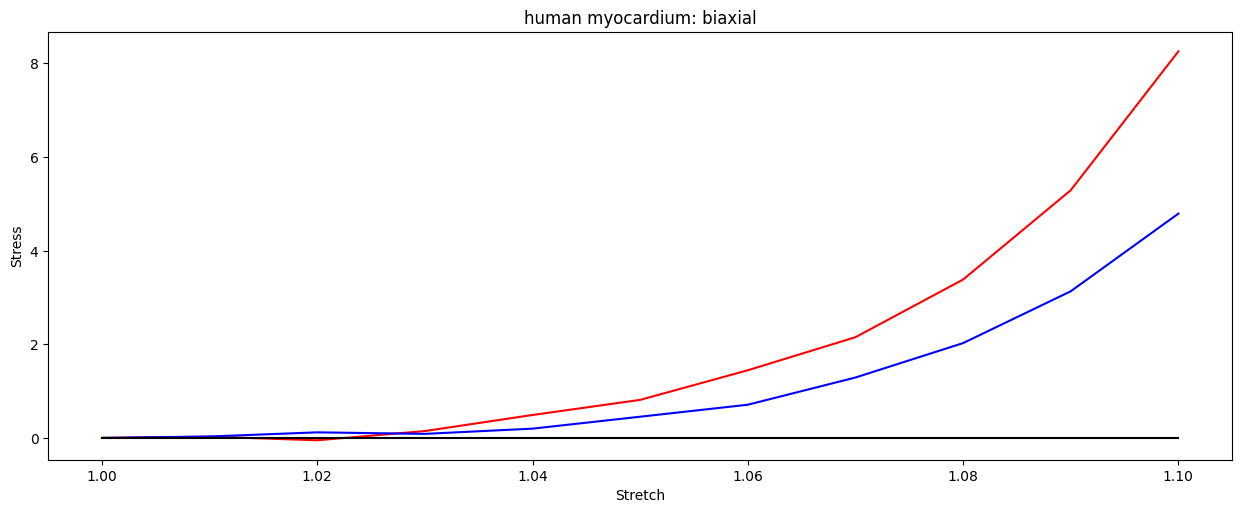

In [6]:
# blot biaxial 1:1
plt.figure(figsize=(1100/72,400/72))
plt.plot(stretch_1010_f, P_1010_f,color='red')
plt.plot(stretch_1010_n, P_1010_n,color='blue')

#plt.plot(gamma_fn,gamma_fn,color='yellow')
plt.plot(np.linspace(1., 1.1, 100), np.linspace(0,0,100),'k')
plt.xlabel('Stretch')
plt.ylabel('Stress')
plt.title('human myocardium: biaxial')

Text(0.5, 1.0, 'human myocardium: shear')

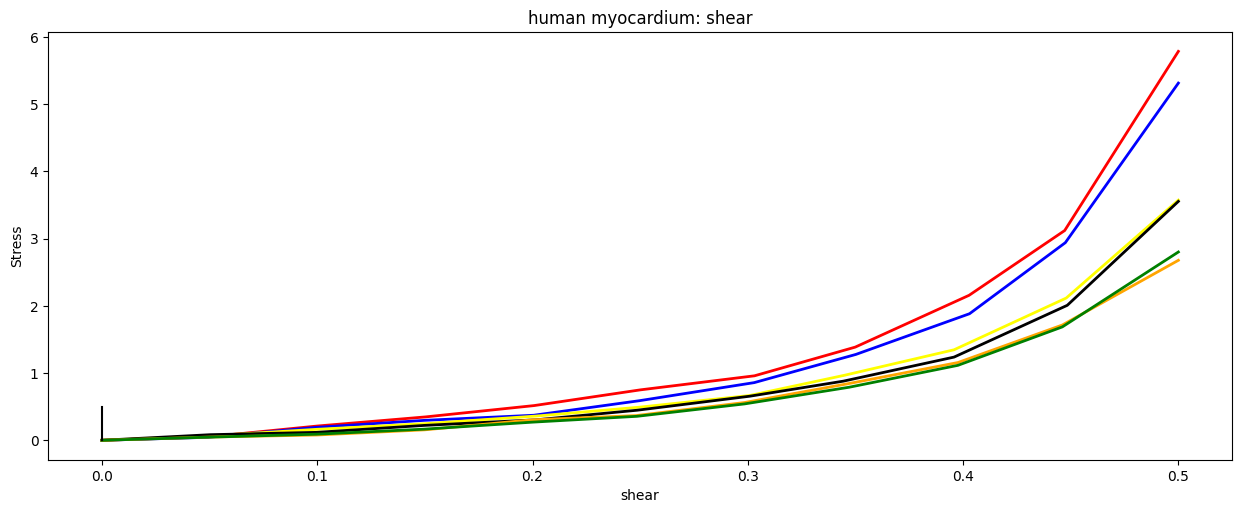

In [7]:
# plotshear
plt.figure(figsize=(1100/72,400/72))
plt.plot(gamma_fs,P_fs, linewidth=2.0,color='red')
plt.plot(gamma_fn,P_fn, linewidth=2.0,color='blue')
plt.plot(gamma_sf,P_sf, linewidth=2.0,color='yellow')
plt.plot(gamma_sn,P_sn, linewidth=2.0,color='black')
plt.plot(gamma_nf,P_nf, linewidth=2.0,color='orange')
plt.plot(gamma_ns,P_ns, linewidth=2.0,color='green')
plt.plot(np.linspace(0, 0, 100), np.linspace(0.0,0.5,100),'k')

plt.xlabel('shear')
plt.ylabel('Stress')
plt.title('human myocardium: shear')

### L1 and L2 regularization with penalty weight



In [8]:
def regularize(reg, pen):
    if reg == 'L2':
        return keras.regularizers.l2(pen)
    if reg == 'L1':
        return keras.regularizers.l1(pen)

## 2. Strain Energy Model - Invariant-based


Next, we define the free energy function for our orthotropic, perfectly incompressible constitutive neural network with two hidden layers and 32 nodes using the invariants of the right Cauchy Green tensor. The first layer generates powers $(\circ)^1$ and $(\circ)^2$ of the network inputs,
$[I_1-3]$, $[I_2-3]$, $[I_{4f}-1]$, $[I_{4s}-1]$, $[I_{4n}-1]$, $[I_{8fs}]$, $[I_{8fn}]$, $[I_{8sn}]$ and the second layer applies the identity, $(\circ)$, the exponential function, $(\rm{exp}((\circ))-1)$.
The set of equations for this networks takes the following explicit form,


$$
\begin{array}{l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{.02cm}}l@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.04cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}l}
    \psi(I_1,I_2,I_{4f},I_{4s},I_{4n},I_{8fs},I_{8fn},I_{8sn})
&=& w_{2,1}&w_{1,1} &[\,I_1 - 3\,]
&+& w_{2,2} & [ \, \exp (\,     w_{1,2} & [\, I_1 -3 \,]&)   - 1\,]
\\
&+& w_{2,3}&w_{1,3} &[\,I_1 - 3\,]^2
&+& w_{2,4} & [ \, \exp (\,     w_{1,4} & [\, I_1 -3 \,]^2&) - 1\,]
\\
&+& w_{2,5}&w_{1,5} &[\,I_2 - 3\,]
&+& w_{2,6} & [ \, \exp (\,     w_{1,6} & [\, I_2 -3 \,]&)   - 1\,]
\\
&+& w_{2,7}&w_{1,7} &[\,I_2 - 3\,]^2
&+& w_{2,8} & [ \, \exp (\,    w_{1,8} & [\, I_2 -3 \,]^2&)- 1\,]
 \\
&+& w_{2,9}&w_{1,9} &[\,I_{4f} - 1\,]
&+& w_{2,10} & [ \, \exp (\,     w_{1,10} & [\, I_{4f} -1 \,]&)   - 1\,]
\\
&+& w_{2,11}&w_{1,11} &[\,I_{4f} - 1\,]^2
&+& w_{2,12} & [ \, \exp (\,     w_{1,12} & [\, I_{4f} -1 \,]^2&) - 1\,]
\\
&...\\
&+& w_{2,21}&w_{1,21} &[\,I_{8fs}\,]
&+& w_{2,22} & [ \, \exp (\,     w_{1,22} & [\, I_{8fs} \,]&)   - 1\,]
\\
&+& w_{2,23}&w_{1,23} &[\,I_{8fs} \,]^2
&+& w_{2,24} & [ \, \exp (\,     w_{1,24} & [\, I_{8fs} \,]^2&) - 1\,]
\\
&...\\
&+& w_{2,29}&w_{1,29} &[\,I_{8sn}\,]
&+& w_{2,30} & [ \, \exp (\,     w_{1,30} & [\, I_{8sn} \,]&)   - 1\,]
\\
&+& w_{2,31}&w_{1,31} &[\,I_{8sn} \,]^2
&+& w_{2,32} & [ \, \exp (\,     w_{1,32} & [\, I_{8sn} \,]^2&) - 1\,]
\end{array}
$$


First we define the activation functions and a single Invariant block:

In [9]:
initializer_exp = tf.keras.initializers.RandomUniform(minval=0., maxval=0.1, seed=np.random.randint(0,10000)) # use random integer as seed
initializer_1 = 'glorot_normal'
# Self defined activation functions for exp term
def activation_Exp(x):
    return 1.0*(tf.math.exp(x)-1.0)
# Self defined activation functions for ln term
def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

# Define network block
## kernel is weight
def SingleInvNet(I1_ref, idi, reg, pen):

    # input: invariant
    I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation, correspont to the top ptahway in graph
    I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(2+idi)+'1')(I1_ref) # exp activation, 2nd line in graph

    # I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                           use_bias=False, activation=activation_ln,name='w'+str(3+idi)+'1')(I1_ref) # ln activation

    # input: invariant^2
    I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(3+idi)+'1')(tf.math.square(I1_ref)) # no activation
    I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    # I_1_w61 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                           use_bias=False, activation=activation_ln,name='w'+str(6+idi)+'1')(tf.math.square(I1_ref)) # ln activation

    collect = [I_1_w11, I_1_w21,  I_1_w31, I_1_w41]
    collect_out = tf.keras.layers.concatenate(collect, axis=1)

    return collect_out

Then we define the strain energy keras submodel as:

In [10]:
def StrainEnergyCANN_invariant(reg, pen):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')
    I4f_in = tf.keras.Input(shape=(1,), name='I4f')
    I4s_in = tf.keras.Input(shape=(1,), name='I4s')
    I4n_in = tf.keras.Input(shape=(1,), name='I4n')
    I8fs_in = tf.keras.Input(shape=(1,), name='I8fs')
    I8fn_in = tf.keras.Input(shape=(1,), name='I8fn')
    I8sn_in = tf.keras.Input(shape=(1,), name='I8sn')

    # Put invariants in the reference configuration (substrct 3)
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)
    I2_ref = keras.layers.Lambda(lambda x: (x-3.0))(I2_in)
    I4f_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4f_in)
    I4s_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4s_in)
    I4n_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4n_in)
    I8fs_ref = keras.layers.Lambda(lambda x: (x))(I8fs_in)
    I8fn_ref = keras.layers.Lambda(lambda x: (x))(I8fn_in)
    I8sn_ref = keras.layers.Lambda(lambda x: (x))(I8sn_in)

    I1_out = SingleInvNet(I1_ref, 0, reg, pen)
    terms = I1_out.get_shape().as_list()[1] # 4 terms per invariant
    I2_out = SingleInvNet(I2_ref, terms, reg, pen)
    I4f_out = SingleInvNet(I4f_ref, 2*terms, reg, pen)
    I4s_out = SingleInvNet(I4s_ref, 3*terms, reg, pen)
    I4n_out = SingleInvNet(I4n_ref, 4*terms, reg, pen)
    I8fs_out = SingleInvNet(I8fs_ref, 5*terms, reg, pen)
    I8fn_out = SingleInvNet(I8fn_ref, 6*terms, reg, pen)
    I8sn_out = SingleInvNet(I8sn_ref, 7*terms, reg, pen)

    ALL_I_out = [I1_out,I2_out,I4f_out,I4s_out,I4n_out,I8fs_out,I8fn_out,I8sn_out]
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out,axis=1)

    # second layer
    ## get 2nd col of weights
    W_ANN = keras.layers.Dense(1,kernel_initializer='glorot_normal',kernel_constraint=keras.constraints.NonNeg(),
                               kernel_regularizer=regularize(reg, pen),
                           use_bias=False, activation=None,name='wx2')(ALL_I_out)
    Psi_model = keras.models.Model(inputs=[I1_in, I2_in, I4f_in, I4s_in, I4n_in, I8fs_in, I8fn_in, I8sn_in], outputs=[W_ANN], name='Psi')

    return Psi_model, terms*8  # 32 terms


### 3. Stress Models



####  Biaxial tension

For the case of biaxial tension, we stretch the specimen in two directions (fibre and cross-fibre (normal) directions,
$F_{ff} = \lambda_1 $ and $F_{nn} = \lambda_2 $
For a perfectly incompressible material we have
$I_3 = \lambda_1^2  \lambda_2^2  \lambda_3^2 = 1$.

For the explicit expressions see https://royalsocietypublishing.org/doi/10.1098/rsta.2009.0091


In [11]:
def Stress_cal_f(inputs):
    (dWI1,dWI2,dWI4_f,dWI4_n,stretch_f,stretch_n,kf,kn) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    three = tf.constant(3.0,dtype='float32')

    #according to Holzapfel 2009 and Errikson
    stretch_s = one/(stretch_f*stretch_n)
    stress_f = two * (dWI1 * (stretch_f*stretch_f - stretch_s*stretch_s)  + dWI2 * (stretch_n*stretch_n*(stretch_f*stretch_f - stretch_s*stretch_s)) + dWI4_f*(stretch_f*stretch_f*(1-2*kf)) + dWI4_n*(stretch_f*stretch_f*kn))
    return stress_f

def Stress_cal_n(inputs):
    (dWI1,dWI2,dWI4_f,dWI4_n,stretch_f,stretch_n,kf,kn) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')

    #according to Holzapfel 2009 and Errikson
    stretch_s = one/(stretch_f*stretch_n)
    stress_n = two * (dWI1 * (stretch_n*stretch_n - stretch_s*stretch_s)  + dWI2 * (stretch_f*stretch_f*(stretch_n*stretch_n - stretch_s*stretch_s))  + dWI4_f*(stretch_n*stretch_n*kf) + dWI4_n*(stretch_n*stretch_n**(1-2*kn)))
    return stress_n

####  Shear

For the case of simple shear, we shear the specimen in 6 direction.

For explicit expressions see https://royalsocietypublishing.org/doi/10.1098/rsta.2009.0091

In [12]:
# Simple shear stress
def stress_cal_ss_ortho(inputs):
    (dPsidI1, dPsidI2, dPsidI4_1,dPsidI4_2,dPsidI8, gamma,k1,k2) = inputs
    two = tf.constant(2.0,dtype='float32')
    stress = two*gamma * (dPsidI1  + dPsidI2 + dPsidI4_1*(1.0-2.0*k1) + dPsidI4_2*k2) + dPsidI8
    return stress


Finally, we can define seperate stress models for biaxial extension and triaxial shear and a combination of all loading states.

In [13]:
from re import X
# Gradient function
## automatic gradients
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]

from keras.constraints import Constraint
class NonNegMaxConstraint(Constraint):
    def __init__(self, max_value=1.0/3.0):
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, 0.0, self.max_value)

# Define H-layer
class H_Layer_kappas(keras.layers.Layer):

    def __init__(self, nameU, setAl, init):
        super(H_Layer_kappas, self).__init__()
        self.nameU = nameU
        self.setAl = setAl
        self.init =  init

        self.kappa_f =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=self.setAl)
        self.kappa_s =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=self.setAl)
        self.kappa_n =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=self.setAl)


    def get_config(self):

        config = super().get_config().copy()

        return config

    def call(self, lam):

        one = tf.constant(1.0,dtype='float32')
        two = tf.constant(2.0,dtype='float32')
        four = tf.constant(4.0,dtype='float32')
        third = tf.constant(1./3,dtype='float32')

        # kf = self.kappa_f
        # ks = self.kappa_s
        # kn = self.kappa_n
        kf=0.0
        ks=0.154
        kn=0.321

        Gamma_fs=lam[0]
        Gamma_fn=lam[1]
        Gamma_sf=lam[2]
        Gamma_sn=lam[3]
        Gamma_nf=lam[4]
        Gamma_ns=lam[5]
        Stretch_f_1=lam[6]
        Stretch_n_1=lam[7]
        Stretch_f_2=lam[8]
        Stretch_n_2=lam[9]
        Stretch_f_3=lam[10]
        Stretch_n_3=lam[11]
        Stretch_f_4=lam[12]
        Stretch_n_4=lam[13]
        Stretch_f_5=lam[14]
        Stretch_n_5=lam[15]

        kf_out=kf*tf.ones_like(lam[0])
        ks_out=ks*tf.ones_like(lam[0])
        kn_out=kn*tf.ones_like(lam[0])

        I4f_fs = kf*(Gamma_fs**2 + 3.0) + (1.0 - 3*kf)*(1.0 + Gamma_fs**2)
        I4s_fs = ks*(Gamma_fs**2 + 3.0) + (1.0 - 3*ks)*Gamma_fs**0
        I4n_fs = kn*(Gamma_fs**2 + 3.0) + (1.0 - 3*kn)*Gamma_fs**0

        I4f_fn = kf*(Gamma_fn**2 + 3.0) + (1.0 - 3*kf)*(1.0 + Gamma_fn**2)
        I4s_fn = ks*(Gamma_fn**2 + 3.0) + (1.0 - 3*ks)*Gamma_fn**0
        I4n_fn = kn*(Gamma_fn**2 + 3.0) + (1.0 - 3*kn)*Gamma_fn**0

        I4s_sf = ks*(Gamma_sf**2 + 3.0) + (1.0 - 3*ks)*(1.0 + Gamma_sf**2)
        I4f_sf = kf*(Gamma_sf**2 + 3.0) + (1.0 - 3*kf)*Gamma_sf**0
        I4n_sf = kn*(Gamma_sf**2 + 3.0) + (1.0 - 3*kn)*Gamma_sf**0

        I4s_sn = ks*(Gamma_sn**2 + 3.0) + (1.0 - 3*ks)*(1.0 + Gamma_sn**2)
        I4f_sn = kf*(Gamma_sn**2 + 3.0) + (1.0 - 3*kf)*Gamma_sn**0
        I4n_sn = kn*(Gamma_sn**2 + 3.0) + (1.0 - 3*kn)*Gamma_sn**0

        I4n_nf = kn*(Gamma_nf**2 + 3.0) + (1.0 - 3*kn)*(1.0 + Gamma_nf**2)
        I4f_nf = kf*(Gamma_nf**2 + 3.0) + (1.0 - 3*kf)*Gamma_nf**0
        I4s_nf = ks*(Gamma_nf**2 + 3.0) + (1.0 - 3*ks)*Gamma_nf**0

        I4n_ns = kn*(Gamma_ns**2 + 3.0) + (1.0 - 3*kn)*(1.0 + Gamma_ns**2)
        I4f_ns = kf*(Gamma_ns**2 + 3.0) + (1.0 - 3*kf)*Gamma_ns**0
        I4s_ns = ks*(Gamma_ns**2 + 3.0) + (1.0 - 3*ks)*Gamma_ns**0

        I4f_bi1 = kf*(Stretch_f_1**2 + Stretch_n_1 **2 + (1./(Stretch_f_1*Stretch_n_1)**2))+ (1.0 - 3*kf)*(Stretch_f_1**2)
        I4s_bi1 = ks*(Stretch_f_1**2 + Stretch_n_1**2 + (1./(Stretch_f_1*Stretch_n_1)**2))+ (1.0 - 3*ks)*((1./(Stretch_f_1*Stretch_n_1))**2)
        I4n_bi1 = kn*(Stretch_f_1**2 + Stretch_n_1**2 + (1./(Stretch_f_1*Stretch_n_1)**2))+ (1.0 - 3*kn)*(Stretch_n_1**2)

        I4f_bi2 = kf*(Stretch_f_2**2 + Stretch_n_2 **2 + (1./(Stretch_f_2*Stretch_n_2)**2))+ (1.0 - 3*kf)*(Stretch_f_2**2)
        I4s_bi2 = ks*(Stretch_f_2**2 + Stretch_n_2**2 + (1./(Stretch_f_2*Stretch_n_2)**2))+ (1.0 - 3*ks)*((1./(Stretch_f_2*Stretch_n_2))**2)
        I4n_bi2 = kn*(Stretch_f_2**2 + Stretch_n_2**2 + (1./(Stretch_f_2*Stretch_n_2)**2))+ (1.0 - 3*kn)*(Stretch_n_2**2)

        I4f_bi3 = kf*(Stretch_f_3**2 + Stretch_n_3 **2 + (1./(Stretch_f_3*Stretch_n_3)**2))+ (1.0 - 3*kf)*(Stretch_f_3**2)
        I4s_bi3 = ks*(Stretch_f_3**2 + Stretch_n_3**2 + (1./(Stretch_f_3*Stretch_n_3)**2))+ (1.0 - 3*ks)*((1./(Stretch_f_3*Stretch_n_3))**2)
        I4n_bi3 = kn*(Stretch_f_3**2 + Stretch_n_3**2 + (1./(Stretch_f_3*Stretch_n_3)**2))+ (1.0 - 3*kn)*(Stretch_n_3**2)

        I4f_bi4 = kf*(Stretch_f_4**2 + Stretch_n_4 **2 + (1./(Stretch_f_4*Stretch_n_4)**2))+ (1.0 - 3*kf)*(Stretch_f_4**2)
        I4s_bi4 = ks*(Stretch_f_4**2 + Stretch_n_4**2 + (1./(Stretch_f_4*Stretch_n_4)**2))+ (1.0 - 3*ks)*((1./(Stretch_f_4*Stretch_n_4))**2)
        I4n_bi4 = kn*(Stretch_f_4**2 + Stretch_n_4**2 + (1./(Stretch_f_4*Stretch_n_4)**2))+ (1.0 - 3*kn)*(Stretch_n_4**2)

        I4f_bi5 = kf*(Stretch_f_5**2 + Stretch_n_5 **2 + (1./(Stretch_f_5*Stretch_n_5)**2))+ (1.0 - 3*kf)*(Stretch_f_5**2)
        I4s_bi5 = ks*(Stretch_f_5**2 + Stretch_n_5**2 + (1./(Stretch_f_5*Stretch_n_5)**2))+ (1.0 - 3*ks)*((1./(Stretch_f_5*Stretch_n_5))**2)
        I4n_bi5 = kn*(Stretch_f_5**2 + Stretch_n_5**2 + (1./(Stretch_f_5*Stretch_n_5)**2))+ (1.0 - 3*kn)*(Stretch_n_5**2)


        return [kf_out,ks_out,kn_out,I4f_fs, I4s_fs, I4n_fs, I4f_fn, I4s_fn, I4n_fn, I4s_sf, I4f_sf, I4n_sf, I4s_sn, I4f_sn, I4n_sn, I4n_nf, I4f_nf, I4s_nf, I4n_ns, I4f_ns, I4s_ns, I4f_bi1, I4s_bi1, I4n_bi1, I4f_bi2, I4s_bi2, I4n_bi2, I4f_bi3, I4s_bi3, I4n_bi3, I4f_bi4, I4s_bi4, I4n_bi4, I4f_bi5, I4s_bi5, I4n_bi5]


def modelArchitecture(Psi_model):
    # Stretch and Gamma as input

    Gamma_fs = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_fs')

    Gamma_fn = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_fn')

    Gamma_sf = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_sf')

    Gamma_sn = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_sn')

    Gamma_nf = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_nf')

    Gamma_ns = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_ns')

    Stretch_f_1 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_1')
    Stretch_n_1 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_1')

    Stretch_f_2 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_2')
    Stretch_n_2 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_2')

    Stretch_f_3 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_3')
    Stretch_n_3 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_3')

    Stretch_f_4 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_4')
    Stretch_n_4 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_4')

    Stretch_f_5 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_5')
    Stretch_n_5 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_5')

    #models for all possible shear modes
    zero = tf.constant(0.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    input=[Gamma_fs, Gamma_fn,Gamma_sf,Gamma_sn,Gamma_nf,Gamma_ns,Stretch_f_1, Stretch_n_1,Stretch_f_2, Stretch_n_2,Stretch_f_3, Stretch_n_3,Stretch_f_4, Stretch_n_4,Stretch_f_5, Stretch_n_5]
    kf,ks,kn,I4f_fs_H, I4s_fs_H, I4n_fs_H, I4f_fn_H, I4s_fn_H, I4n_fn_H, I4s_sf_H, I4f_sf_H, I4n_sf_H, I4s_sn_H, I4f_sn_H, I4n_sn_H, I4n_nf_H, I4f_nf_H, I4s_nf_H, I4n_ns_H, I4f_ns_H, I4s_ns_H, I4f_bi1_H, I4s_bi1_H, I4n_bi1_H, I4f_bi2_H, I4s_bi2_H, I4n_bi2_H, I4f_bi3_H, I4s_bi3_H, I4n_bi3_H, I4f_bi4_H, I4s_bi4_H, I4n_bi4_H, I4f_bi5_H, I4s_bi5_H, I4n_bi5_H = H_Layer_kappas('kappa',True, 0.05)(input)

    #(fs)
    I1_fs = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fs)
    I2_fs = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fs)
    I4f_fs = keras.layers.Lambda(lambda x: x)(I4f_fs_H)
    I4s_fs = keras.layers.Lambda(lambda x: x)(I4s_fs_H)
    I4n_fs = keras.layers.Lambda(lambda x: x)(I4n_fs_H)
    I8fs_fs = keras.layers.Lambda(lambda x: x**1)(Gamma_fs)
    I8fn_fs = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fs)
    I8sn_fs = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fs)
    Psi_fs = Psi_model([I1_fs,I2_fs,I4f_fs,I4s_fs,I4n_fs,I8fs_fs,I8fn_fs,I8sn_fs])
    dWI1_fs  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I1_fs])
    dWdI2_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I2_fs])
    dWdI4f_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I4f_fs])
    dWdI4s_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I4s_fs])
    dWdI8fs_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I8fs_fs])
    Stress_fs = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_fs')([dWI1_fs,dWdI2_fs,dWdI4f_fs,dWdI4s_fs,dWdI8fs_fs,Gamma_fs,kf,ks])
    #(fn)
    I1_fn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fn)
    I2_fn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fn)
    I4f_fn = keras.layers.Lambda(lambda x: x)(I4f_fn_H)
    I4s_fn = keras.layers.Lambda(lambda x:  x)(I4s_fn_H)
    I4n_fn = keras.layers.Lambda(lambda x: x)(I4n_fn_H)
    I8fn_fn = keras.layers.Lambda(lambda x: x**1)(Gamma_fn)
    I8fs_fn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fn)
    I8sn_fn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fn)
    Psi_fn = Psi_model([I1_fn, I2_fn,I4f_fn,I4s_fn,I4n_fn,I8fs_fn,I8fn_fn,I8sn_fn])
    dWI1_fn  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I1_fn])
    dWdI2_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I2_fn])
    dWdI4f_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I4f_fn])
    dWdI4n_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I4n_fn])
    dWdI8fn_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I8fn_fn])
    Stress_fn = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_fn')([dWI1_fn,dWdI2_fn,dWdI4f_fn,dWdI4n_fn,dWdI8fn_fn, Gamma_fn,kf,kn])
    #(sf)
    I1_sf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sf)
    I2_sf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sf)
    I4s_sf = keras.layers.Lambda(lambda x: x)(I4s_sf_H)
    I4f_sf = keras.layers.Lambda(lambda x: x)(I4f_sf_H)
    I4n_sf = keras.layers.Lambda(lambda x: x)(I4n_sf_H)
    I8fs_sf = keras.layers.Lambda(lambda x: x**1)(Gamma_sf)
    I8fn_sf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sf)
    I8sn_sf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sf)
    Psi_sf = Psi_model([I1_sf, I2_sf,I4f_sf,I4s_sf,I4n_sf,I8fs_sf,I8fn_sf,I8sn_sf])
    dWI1_sf  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I1_sf])
    dWdI2_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I2_sf])
    dWdI4s_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I4s_sf])
    dWdI4f_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I4f_sf])
    dWdI8fs_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I8fs_sf])
    Stress_sf = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_sf')([dWI1_sf,dWdI2_sf,dWdI4s_sf,dWdI4f_sf,dWdI8fs_sf,Gamma_sf,ks,kf])
    #(sn)
    I1_sn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sn)
    I2_sn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sn)
    I4s_sn = keras.layers.Lambda(lambda x: x)(I4s_sn_H)
    I4f_sn = keras.layers.Lambda(lambda x: x)(I4f_sn_H)
    I4n_sn = keras.layers.Lambda(lambda x: x)(I4n_sn_H)
    I8sn_sn = keras.layers.Lambda(lambda x: x**1)(Gamma_sn)
    I8fs_sn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sn)
    I8fn_sn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sn)
    Psi_sn = Psi_model([I1_sn, I2_sn,I4f_sn,I4s_sn,I4n_sn,I8fs_sn,I8fn_sn,I8sn_sn])
    dWI1_sn  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I1_sn])
    dWdI2_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I2_sn])
    dWdI4s_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I4s_sn])
    dWdI4n_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I4n_sn])
    dWdI8sn_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I8sn_sn])
    Stress_sn = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_sn')([dWI1_sn,dWdI2_sn,dWdI4s_sn,dWdI4n_sn,dWdI8sn_sn,Gamma_sn,ks,kn])
    #(nf)
    I1_nf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_nf)
    I2_nf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_nf)
    I4n_nf = keras.layers.Lambda(lambda x: x)(I4n_nf_H)
    I4f_nf = keras.layers.Lambda(lambda x: x)(I4f_nf_H)
    I4s_nf = keras.layers.Lambda(lambda x: x)(I4s_nf_H)
    I8fn_nf = keras.layers.Lambda(lambda x: x**1)(Gamma_nf)
    I8fs_nf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_nf)
    I8sn_nf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_nf)
    Psi_nf = Psi_model([I1_nf, I2_nf,I4f_nf,I4s_nf,I4n_nf,I8fs_nf,I8fn_nf,I8sn_nf])
    dWI1_nf  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I1_nf])
    dWdI2_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I2_nf])
    dWdI4n_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I4n_nf])
    dWdI4f_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I4f_nf])
    dWdI8fn_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I8fn_nf])
    Stress_nf = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_nf')([dWI1_nf,dWdI2_nf,dWdI4n_nf,dWdI4f_nf,dWdI8fn_nf,Gamma_nf,kn,kf])
    #(ns)
    I1_ns = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_ns)
    I2_ns = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_ns)
    I4n_ns = keras.layers.Lambda(lambda x: x)(I4n_ns_H)
    I4f_ns = keras.layers.Lambda(lambda x: x)(I4f_ns_H)
    I4s_ns = keras.layers.Lambda(lambda x: x)(I4s_ns_H)
    I8sn_ns = keras.layers.Lambda(lambda x: x**1)(Gamma_ns)
    I8fs_ns = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_ns)
    I8fn_ns = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_ns)
    Psi_ns = Psi_model([I1_ns, I2_ns,I4f_ns,I4s_ns,I4n_ns,I8fs_ns,I8fn_ns,I8sn_ns])
    dWI1_ns  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I1_ns])
    dWdI2_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I2_ns])
    dWdI4n_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I4n_ns])
    dWdI4s_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I4s_ns])
    dWdI8sn_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I8sn_ns])
    Stress_ns = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_ns')([dWI1_ns,dWdI2_ns,dWdI4n_ns,dWdI4s_ns,dWdI8sn_ns,Gamma_ns,kn,ks])

   # biaxial
   # first biaxial model
    Stretch_f=Stretch_f_1
    Stretch_n=Stretch_n_1
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x )(I4f_bi1_H)
    I4s_bi = keras.layers.Lambda(lambda x: x)(I4s_bi1_H)
    I4n_bi = keras.layers.Lambda(lambda x: x)(I4n_bi1_H)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f_1 = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f1')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    Stress_n_1 = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n1')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    # second biaxial model
    Stretch_f=Stretch_f_2
    Stretch_n=Stretch_n_2
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x )(I4f_bi2_H)
    I4s_bi = keras.layers.Lambda(lambda x: x)(I4s_bi2_H)
    I4n_bi = keras.layers.Lambda(lambda x: x)(I4n_bi2_H)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f_2 = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f2')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    Stress_n_2 = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n2')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])

    # 3rd biaxial model
    Stretch_f=Stretch_f_3
    Stretch_n=Stretch_n_3
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x )(I4f_bi3_H)
    I4s_bi = keras.layers.Lambda(lambda x: x)(I4s_bi3_H)
    I4n_bi = keras.layers.Lambda(lambda x: x)(I4n_bi3_H)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f_3 = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f3')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    Stress_n_3 = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n3')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])

    # 4th biaxial model
    Stretch_f=Stretch_f_4
    Stretch_n=Stretch_n_4
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x )(I4f_bi4_H)
    I4s_bi = keras.layers.Lambda(lambda x: x)(I4s_bi4_H)
    I4n_bi = keras.layers.Lambda(lambda x: x)(I4n_bi4_H)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f_4 = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f4')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    Stress_n_4 = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n4')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])

    # 5th biaxial model
    Stretch_f=Stretch_f_5
    Stretch_n=Stretch_n_5
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x )(I4f_bi5_H)
    I4s_bi = keras.layers.Lambda(lambda x: x)(I4s_bi5_H)
    I4n_bi = keras.layers.Lambda(lambda x: x)(I4n_bi5_H)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f_5 = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f5')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])
    Stress_n_5 = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n5')([dWI1_bi,dWdI2_bi,dWdI4f_bi,dWdI4n_bi,Stretch_f,Stretch_n,kf,kn])

    input=[Gamma_fs,Gamma_fn,Gamma_sf,Gamma_sn,Gamma_nf,Gamma_ns,
         Stretch_f_1, Stretch_n_1,Stretch_f_2, Stretch_n_2,Stretch_f_3, Stretch_n_3,Stretch_f_4, Stretch_n_4,Stretch_f_5, Stretch_n_5]
    output=[Stress_fs,Stress_fn,Stress_sf,Stress_sn,Stress_nf,Stress_ns,Stress_f_1,Stress_n_1, Stress_f_2,Stress_n_2,Stress_f_3, Stress_n_3,Stress_f_4,Stress_n_4,Stress_f_5,Stress_n_5]
    model_sh_bi = keras.models.Model(inputs=input,outputs=output)

    return  model_sh_bi, Psi_model


### 4. Compile model

The compiler definition comprises the loss function definition (here a mean squared error metric), the optimizer (here an Adam optimizer) and the evaluation metric (also mean squared error).

Moreover, we define model callbacks and the keras fit function. The latter obtains the information about which model we want to fit with which data.

In [14]:
# Optimization utilities
def Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  =[keras.metrics.MeanSquaredError()]
    opti1    = tf.optimizers.Adam(learning_rate=0.001)

    model_given.compile(loss=mse_loss,
                  optimizer=opti1,
                  metrics=metrics)

    # if training loss starts to increase, stop training after 1000 additional epochs = "patience"
    ## early stopping if loss increasing innstead of decreasing

    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.001, patience=1000, restore_best_weights=True)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True, # save only the best weights across all epochs
    )

## model.fit - input/output pairs of data to train on
## sample_weights is how much each exampe is weighted in the loss fct
    history = model_given.fit(input_train,
                        output_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.0,
                        callbacks=[es_callback, modelckpt_callback], # save best weights if stop early or go through all epochs
                        shuffle = True,
                        verbose = 0) # verbose = 2 will print loss each epoch
                        # sample_weight = sample_weights)
    return model_given, history


### 5. Plot functions

Here we define some plot functions to be used to plot the results later on

In [15]:
def plotLoss(axe, history):
    axe.plot(history)
    axe.set_yscale('log')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [16]:
# plot the contribution of each term to the model stress prediction
# shear stress
def color_map(ax, stretch, model, model_weights, Psi_model, cmaplist, terms, model_type):
    predictions = np.zeros([stretch.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights

    for i in range(terms):
        if model_type == 'Stretch':
            model_plot = np.zeros_like(model_weights)  # wx1 all set to zero
            model_plot[i] = model_weights[i]  # wx1[i] set to trained value
        else:  # for architectures with multiple layers (VL, invariant)
            model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
            model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

        Psi_model.set_weights(model_plot)
        lower = np.sum(predictions, axis=1)
        upper = lower + model.predict(stretch, verbose=0)[:].flatten()
        predictions[:, i] = model.predict(stretch, verbose=0)[:].flatten()
        ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
        ## plot each term's contribution

        ax.plot(stretch, upper, lw=0.4, zorder=34, color='k')

# biaxial stress
def color_map_bi(ax, lamx, lamy,lamplot, model, model_weights, Psi_model, cmaplist, terms, label):
    predictions = np.zeros([lamx.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights
    for i in range(terms):
      #invarant based model
      model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
      model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

      Psi_model.set_weights(model_plot)
      lower = np.sum(predictions, axis=1)
      if label == 'x':
            upper = lower +  model.predict([lamx, lamy],verbose=0)[0][:].flatten()
            predictions[:,i] = model.predict([lamx, lamy],verbose=0)[0][:].flatten()
      else:
            upper = lower +  model.predict([lamx, lamy],verbose=0)[1][:].flatten()
            predictions[:,i] = model.predict([lamx, lamy],verbose=0)[1][:].flatten()

      ax.fill_between(lamplot[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
      ax.plot(lamplot, upper, lw=0.4, zorder=34, color='k')



In [17]:
plt.rcParams['xtick.major.pad'] = 32 # set plotting parameters

def plotMapShear(ax, Psi_model, model_weights, model_SS, terms, gamma_SS, P_SS, Region, path2saveResults, modelFit_mode, model_type,label):

    if model_type == 'Invariant':
        numTerms = 32
    elif model_type == 'Stretch':
        numTerms = 32 # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([])
    ax.set_xlim(0.0, 0.5)
    if label == 'fs':
      y_max=5.80
    elif label == 'fn':
      y_max=5.35
    elif label == 'sf':
      y_max=3.60
    elif label == 'sn':
      y_max=3.55
    elif label == 'nf':
      y_max=2.70
    elif label == 'ns':
      y_max=2.80
    ax.set_yticks([])
    ax.set_ylim(0, y_max)

    color_map(ax, gamma_SS, model_SS, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(gamma_SS, P_SS, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    #plt.scatter(gamma_SS, P_SS,color='red')
    #ax.legend(loc='upper left', fancybox=True, framealpha=0., fontsize=14, ncol=2)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Shear_' +  '_'+ label +'_Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.show()
    #plt.close();

    # plot biaxial tension
def plotMapBi(ax, Psi_model, model_weights, model_bi, terms, lamx, lamy,lamplot, P_ut, Region, path2saveResults, modelFit_mode, model_type, label1,label2):
    if model_type == 'Invariant':
        numTerms = 32
    elif model_type == 'Stretch':
        numTerms = 32  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    # this way, we can use 1 or 2 term models and have the colors be the same for those terms
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([1.,1.04, 1.06, 1.08, 1.1])
    ax.set_xlim(1.,1.1)
    if label2 == '1010x':
      x_max=1.1
      x_min=1.0
      y_max=8.3
    elif label2 == '1010y':
      x_max=1.1
      x_min=1.0
      y_max=4.8
    elif label2 == '1007x':
      x_max=1.1
      x_min=1.0
      y_max=5.9
    elif label2 == '1007y':
      x_max=1.075
      x_min=1.0
      y_max=2.8
    elif label2 == '0710x':
      x_max=1.075
      x_min=1.0
      y_max=3.7
    elif label2 == '0710y':
      x_max=1.1
      x_min=1.0
      y_max=2.80
    elif label2 == '1005x':
      x_max=1.1
      x_min=1.0
      y_max=4.8
    elif label2 == '1005y':
      x_max=1.05
      x_min=1.0
      y_max=1.8
    elif label2 == '0510x':
      x_max=1.05
      x_min=1.0
      y_max=2.5
    elif label2 == '0510y':
      x_max=1.1
      x_min=1.0
      y_max=3.1

    ax.set_xticks([])
    ax.set_xlim(x_min, x_max)
    ax.set_yticks([])
    ax.set_ylim(0.0, y_max)

    color_map_bi(ax, lamx, lamy,lamplot, model_bi, model_weights, Psi_model, cmaplist, terms, label1)
    ax.scatter(lamplot, P_ut,color='red')
    ax.scatter(lamplot, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Biaxial_' +  '_'+ label2 +'_Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.show()
    #plt.close();


### 6. Model Training

Parameters and definitions for the model training. Try changing the number of epochs and toggling between the invariant and principal-stretch-based model. Make sure to rename the model_type variable for each test.

In [18]:
train = False
epochs = 40000 # try ~20,000 epochs for a good fit
batch_size = 32

### Choose regularization type & penalty amount
# Option: 'L1', 'L2'
reg = 'L1'
pen = 0.01 # Use 0 for no regularization

folder_name = 'dispersion_kappa_trainable_'+str(epochs)+'_'+ str(batch_size)+'_'+str(pen) # name the folder for your results

### Choose which model type to build CANN architecture with
# Options: 'Invariant'
model_type = 'Invariant'

### Choose which loading modes to train with
# shear_all  all 6 shear tests simultaneously
# biaxial_all  all biaxial tests simultaneously
# biaxial_shear_all all tests simulataneously
modelFit_mode_all = ['biaxial_shear_all']

### Choose which types of tissue to train with
# Options: 'heart'
Region_all = ['heart']
################################################

def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)


filename = 'HeartCANN'
path2saveResults_0 = path + 'results_dispersion_kappa_train/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)
Model_summary = path2saveResults_0 + '/Model_summary.txt'

In [ ]:
#  Training and validation loop
count = 1
for id1, Region in enumerate(Region_all): # loop through  data

    #R2_all_Regions = []
    for id2, modelFit_mode in enumerate(modelFit_mode_all): # loop through model training modes

        print(40*'=')
        print("Comp {:d} / {:d}".format(count, len(Region_all)*len(modelFit_mode_all)))
        print(40*'=')
        print("Region: ", Region ,"| Fitting Mode: ", modelFit_mode)
        print(40*'=')
        count += 1

        path2saveResults = os.path.join(path2saveResults_0,Region, modelFit_mode)
        path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)

        (P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
        P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
        P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
        P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
        P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
        P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n) = getStressStrain(Region_test)

        # Model selection
        if model_type == 'Invariant':
            Psi_model, terms = StrainEnergyCANN_invariant(reg, pen) # build invariant-based model

        elif model_type == 'Stretch':
            Psi_model, terms = StrainEnergyCANN_stretch(reg, pen) # build principle-stretch-based model

        model_sh_bi, Psi_model = modelArchitecture(Psi_model)
        # build uniaxial and shear models


        with open(Model_summary,'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            Psi_model.summary(line_length=80, print_fn=lambda x: fh.write(x + '\n')) # summarize layers in architecture

        #%%  Model training
        model_given, input_train, output_train = traindata(modelFit_mode) # model type, input/output pairs

        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights'
        path_checkpoint = path2saveResults_check + '/best_weights'
        if train: # use compile/fit parameters to train specific model with specific input/output pairs
            model_given, history = Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint)

            model_given.load_weights(path_checkpoint, by_name=False, skip_mismatch=False) # load the weights saved in the path (the best ones)
            tf.keras.models.save_model(Psi_model, Save_path, overwrite=True) # save the model
            Psi_model.save_weights(Save_weights, overwrite=True) # save the weights

            # Plot loss function
            loss_history = history.history['loss']
            fig, axe = plt.subplots(figsize=[6, 5])  # inches
            plotLoss(axe, loss_history)
            plt.savefig(path2saveResults+'/Plot_loss_'+Region+'_'+modelFit_mode+'.pdf')
            plt.show()
            #plt.close()

        else: # if already trained, just load the saved weights
            Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


        # Get CANN model response
        Stress_predict = model_given.predict(input_train, verbose=0)

        Stress_predict_fs = Stress_predict[0]
        Stress_predict_fn = Stress_predict[1]
        Stress_predict_sf = Stress_predict[2]
        Stress_predict_sn = Stress_predict[3]
        Stress_predict_nf = Stress_predict[4]
        Stress_predict_ns = Stress_predict[5]

        #Stress_predict_1010 = model_bi.predict([stretch_1010_f,stretch_1010_n], verbose=0)
        Stress_predict_1010_f = Stress_predict[6]
        Stress_predict_1010_n = Stress_predict[7]

        #Stress_predict_0710 = model_bi.predict([stretch_0710_f,stretch_0710_n], verbose=0)
        Stress_predict_0710_f = Stress_predict[8]
        Stress_predict_0710_n = Stress_predict[9]

        #Stress_predict_1007 = model_bi.predict([stretch_1007_f,stretch_1007_n], verbose=0)
        Stress_predict_1007_f = Stress_predict[10]
        Stress_predict_1007_n = Stress_predict[11]

        #Stress_predict_0510 = model_bi.predict([stretch_0510_f,stretch_0510_n], verbose=0)
        Stress_predict_0510_f = Stress_predict[12]
        Stress_predict_0510_n = Stress_predict[13]

        #Stress_predict_1005 = model_bi.predict([stretch_1005_f,stretch_1005_n], verbose=0)
        Stress_predict_1005_f = Stress_predict[14]
        Stress_predict_1005_n = Stress_predict[15]


        # Save trained weights and R2 values to txt file
        Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen,'r2 total': R2_total,'rms total': rms_total,"r2_fs": R2_fs, "r2_fn": R2_fn, "r2_sf": R2_sf, "r2_sn": R2_sn,"r2_1010_f":R2_1010_f,"r2_1010_n":R2_1010_n,
                     "kf": kf.tolist(),"ks": ks.tolist(),"kn": kn.tolist(),"weights": weight_matrix.tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))


        # Show weights
        if model_type == 'Stretch':
            weight_matrix = np.empty((terms, 1))
            for i in range(terms):
                value = Psi_model.get_weights()[i]
                weight_matrix[i] = value
            print("weight_matrix")
            print(*weight_matrix, sep="\n")

        elif model_type == 'Invariant':
            weight_matrix = np.empty((terms, 2))
            for i in range(terms):
                value = Psi_model.get_weights()[i][0][0]
                weight_matrix[i, 0] = value
                weight_matrix[:, 1] = Psi_model.get_layer('wx2').get_weights()[0].flatten()
            print("weight_matrix")
            print(weight_matrix)
        kf=model_given.get_weights()[0]
        ks=model_given.get_weights()[1]
        kn=model_given.get_weights()[2]
        print("kf,ks,kn")
        print(kf,kn,ks)

        # Get the trained weights
        model_weights_0 = Psi_model.get_weights()

        #print R2
        R2_fs = r2_score(P_fs, Stress_predict_fs)
        print('R2 fs = ', R2_fs)

        R2_fn = r2_score(P_fn, Stress_predict_fn)
        print('R2 fn = ', R2_fn)

        R2_sf = r2_score(P_sf, Stress_predict_sf)
        print('R2 sf = ', R2_sf)

        R2_sn = r2_score(P_sn, Stress_predict_sn)
        print('R2 sn = ', R2_sn)

        R2_nf = r2_score(P_nf, Stress_predict_nf)
        print('R2 nf = ', R2_nf)

        R2_ns = r2_score(P_ns, Stress_predict_ns)
        print('R2 ns = ', R2_ns)

        R2_1010_f = r2_score(P_1010_f, Stress_predict_1010_f)
        print('R2_1010_f = ', R2_1010_f)

        R2_1010_n = r2_score(P_1010_n, Stress_predict_1010_n)
        print('R2_1010_n = ', R2_1010_n)

        R2_1005_f = r2_score(P_1005_f, Stress_predict_1005_f)
        print('R2_1005_f = ', R2_1005_f)

        R2_1005_n = r2_score(P_1005_n, Stress_predict_1005_n)
        print('R2_1005_n = ', R2_1005_n)

        R2_0510_f = r2_score(P_0510_f, Stress_predict_0510_f)
        print('R2_0510_f = ', R2_0510_f)

        R2_0510_n = r2_score(P_0510_n, Stress_predict_0510_n)
        print('R2_0510_n = ', R2_0510_n)

        R2_1007_f = r2_score(P_1007_f, Stress_predict_1007_f)
        print('R2_1007_f = ', R2_1007_f)

        R2_1007_n = r2_score(P_1007_n, Stress_predict_1007_n)
        print('R2_1007_n = ', R2_1007_n)

        R2_0710_f = r2_score(P_0710_f, Stress_predict_0710_f)
        print('R2_0710_f = ', R2_0710_f)

        R2_0710_n = r2_score(P_0710_n, Stress_predict_0710_n)
        print('R2_0710_n = ', R2_0710_n)

        R2_total = 1./16*(R2_fs + R2_fn + R2_sf + R2_sn+ R2_nf+ R2_ns + R2_1010_f + R2_1010_n+ R2_1007_f+ R2_1007_n + R2_0710_f + R2_0710_n + R2_1005_f+ R2_1005_n + R2_0510_f + R2_0510_n)
        print('R2_total = ', R2_total)

        #print rms

        rms_fs = mean_squared_error(P_fs, Stress_predict_fs)
        print('rms fs = ', rms_fs)

        rms_fn = mean_squared_error(P_fn, Stress_predict_fn)
        print('rms fn = ', rms_fn)

        rms_sf = mean_squared_error(P_sf, Stress_predict_sf)
        print('rms sf = ', rms_sf)

        rms_sn = mean_squared_error(P_sn, Stress_predict_sn)
        print('rms sn = ', rms_sn)

        rms_nf = mean_squared_error(P_nf, Stress_predict_nf)
        print('rms nf = ', rms_nf)

        rms_ns = mean_squared_error(P_ns, Stress_predict_ns)
        print('rms ns = ', rms_ns)

        rms_1010_f = mean_squared_error(P_1010_f, Stress_predict_1010_f)
        print('rms_1010_f = ', rms_1010_f)

        rms_1010_n = mean_squared_error(P_1010_n, Stress_predict_1010_n)
        print('rms_1010_n = ', rms_1010_n)

        rms_1005_f = mean_squared_error(P_1005_f, Stress_predict_1005_f)
        print('rms_1005_f = ', rms_1005_f)

        rms_1005_n = mean_squared_error(P_1005_n, Stress_predict_1005_n)
        print('rms_1005_n = ', rms_1005_n)

        rms_0510_f = mean_squared_error(P_0510_f, Stress_predict_0510_f)
        print('rms_0510_f = ', rms_0510_f)

        rms_0510_n = mean_squared_error(P_0510_n, Stress_predict_0510_n)
        print('rms_0510_n = ', rms_0510_n)

        rms_1007_f = mean_squared_error(P_1007_f, Stress_predict_1007_f)
        print('rms_1007_f = ', rms_1007_f)

        rms_1007_n = mean_squared_error(P_1007_n, Stress_predict_1007_n)
        print('rms_1007_n = ', rms_1007_n)

        rms_0710_f = mean_squared_error(P_0710_f, Stress_predict_0710_f)
        print('rms_0710_f = ', rms_0710_f)

        rms_0710_n = mean_squared_error(P_0710_n, Stress_predict_0710_n)
        print('rms_0710_n = ', rms_0710_n)

        rms_total = 1./16*(rms_fs + rms_fn + rms_sf + rms_sn+ rms_nf+ rms_ns + rms_1010_f + rms_1010_n+ R2_1007_f+ rms_1007_n + rms_0710_f + rms_0710_n + rms_1005_f+ R2_1005_n + rms_0510_f + rms_0510_n)
        print('rms_total = ', rms_total)

          # Save trained weights and R2 values to txt file
        Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen,'r2 total': R2_total,'rms total': rms_total,"r2_fs": R2_fs, "r2_fn": R2_fn, "r2_sf": R2_sf, "r2_sn": R2_sn,"r2_1010_f":R2_1010_f,"r2_1010_n":R2_1010_n,
                     "kf": kf.tolist(),"ks": ks.tolist(),"kn": kn.tolist(),"weights": weight_matrix.tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))

